In [172]:
import matplotlib.pyplot as plt
import numpy as np
import sys

# sys.path.insert(1, 'mdp-world-model/data_generation/simulations')
sys.path.append("../simulations")
sys.path.append("../models")
# TODO make this import better!!!

from grid import Grid
from create_plots import plot_2D_vector_field

from tech_substitution import TechnologySubstitution, NumericalSolver



In [173]:
def create_2D_vectorfield(X1, X2, control, solver):
    """
    Computes the vector field components (U, V) on a meshgrid (X1, X2).
    #TODO fix this also for models with more than 2 dimensions (by projection or something).
    #TODO make this more efficient by using vectorized operations, doesn't work yet.

    Parameters:
    X1, X2 (2D arrays): Meshgrid coordinates, assumed to be of the same dimension.
    control: control parameter, expected as an array
    solver: Solver class connected to a model

    Return:
    U, V: (2D arrays): Vector components at each grid point.

    """
    #TODO Check vectorized version

    nrows, ncols = X1.shape

    U = np.zeros_like(X1)  # Placeholder for dx/dt
    V = np.zeros_like(X2)  # Placeholder for dy/dt

    #TRY TO VECTORIZE IT... but doesn't work yet for higher resolutions
    X = np.column_stack((X1.ravel(), X2.ravel()))
    #control_stacked = np.repeat(control, X.shape[0]) #here also check if control has 1 entry or n_samples many
    #derivatives = solver.solve_equilibrium(X, control_stacked)
    #U = derivatives[:,0].reshape(nrows, ncols)
    #V = derivatives[:,1].reshape(nrows, ncols)
    
    
    if True:
        # Loop through each point in the meshgrid
        for i in range(X1.shape[0]):
            for j in range(X1.shape[1]):
                state = np.array([X1[i, j], X2[i, j]])  # Current state vector
                state = np.atleast_2d(state)
                derivatives = solver.get_derivative(state, control).ravel()    # Evaluate 
                U[i, j] = derivatives[0]            # dx/dt
                V[i, j] = derivatives[1]            # dy/dt

    return U, V


In [174]:
def zero_vectorfield(X, Y):
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    return U, V


In [175]:
def plot_2D_vector_field_over_grid(grid, solver, control, trafo_derivative = None, dim1 = 0, dim2 = 1, resolution=50, streamplot=True):
    
    #TODO make this work for transformed spaces
    
    bounds = [grid.tf_bounds[dim1], grid.tf_bounds[dim2]]
    X1lin = np.linspace(bounds[0][0], bounds[0][1], resolution)
    X2lin = np.linspace(bounds[1][0], bounds[1][1], resolution)
    X1, X2 = np.meshgrid(X1lin, X2lin)
    
    fig, ax = plt.subplots(figsize=(8, 8))

    if grid.transformed_bool:
        
        X1_org = np.vectorize(grid.inverse_transformation[dim1])(X1)
        X2_org = np.vectorize(grid.inverse_transformation[dim2])(X2)
    
        U_org, V_org = create_2D_vectorfield(X1_org, X2_org, control=control, solver=solver)
        
        #QUESTION: How to transform a vectorfield?
        #First Try: Handle it as linear vectors, transform start and end points, 
        #Problem here might be non-linearity
        #U = np.vectorize(grid.transformation[dim1])(U_org + X1_org) - X1
        #V = np.vectorize(grid.transformation[dim2])(V_org + X2_org) - X2
        
        #Second Try: Handle it as derivative, multiply with jacobian
        U = np.multiply(np.vectorize(trafo_derivative)(X1_org), U_org)
        V = np.multiply(np.vectorize(trafo_derivative)(X2_org), V_org)


               
    else:
        
        U, V = create_2D_vectorfield(X1, X2, control=control, solver=solver)
    
    
    ax.quiver(X1, X2, U, V, color='b', alpha=0.3)
    
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('2D Vector Field')
    ax.grid(True)

    if streamplot:
        ax.streamplot(X1, X2, U, V, color='b', linewidth=0.7, density=1)


    if grid.transformed_bool:
        #TODO implement this 
        labels = [item for item in ax.get_xticklabels()]
        print(labels)
        #labels_tf = [grid.inverse_transformation[dim1](float(item)) for item in labels]
        ax.set_xticklabels(labels)

    fig.show()

    
    return

### Example Usage

#### Direct Vectorfield Plotting

In [176]:
def test_vectorfield(X, Y):
    U = Y
    V = -X
    return U, V

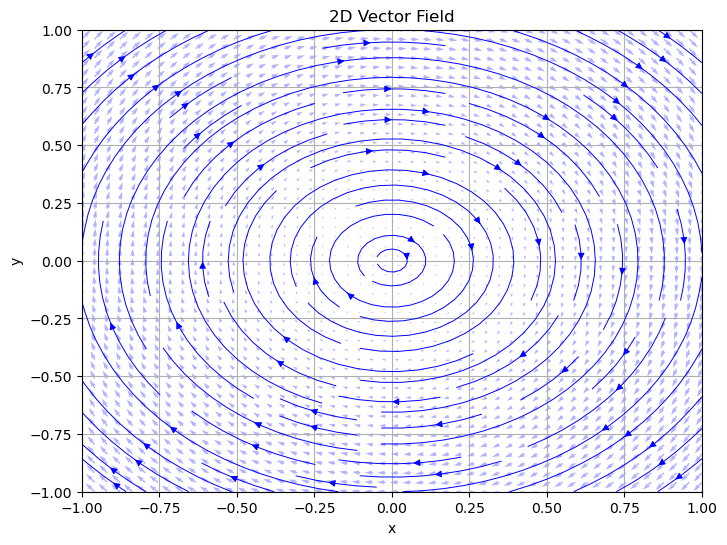

In [177]:
plot_2D_vector_field(test_vectorfield, [[-1, 1], [-1, 1]])

#### Vectorfield from Model over Grid

In [178]:
myinfbounds = [(0, np.inf), (0, np.inf)]
myresolution = [10, 10]
myeasybounds = [(0,100), (0, 100)]
myeasyresolution = [10, 10]

def mytransformation(x):
    if np.isinf(x):
        return 1
    else:
        return x / (x+0.3)

def myinverse_transformation(y):
    if y == 1:
        return np.inf
    else:
        return -0.3*y / (y-1)
    
def mytransformation_derivative(x):
    if np.isinf(x):
        return 0
    else:
        return 0.3 / (x+0.3)**2

infgrid = Grid(myinfbounds, myresolution, mytransformation, myinverse_transformation)
easygrid = Grid(myeasybounds, myeasyresolution)
    

In [179]:
model = TechnologySubstitution(D0=1.0, delta=1.0, sigma=0.2, alpha=0.5, gamma1=1.0)
solver = NumericalSolver(model)

In [180]:
#Test Case

bounds = myeasybounds
X1 = np.linspace(bounds[0][0], bounds[0][1], 10)
X2 = np.linspace(bounds[1][0], bounds[1][1], 10)
X1, X2 = np.meshgrid(X1, X2)
U, V = create_2D_vectorfield(X1, X2, control=np.array([0.5]), solver=solver)

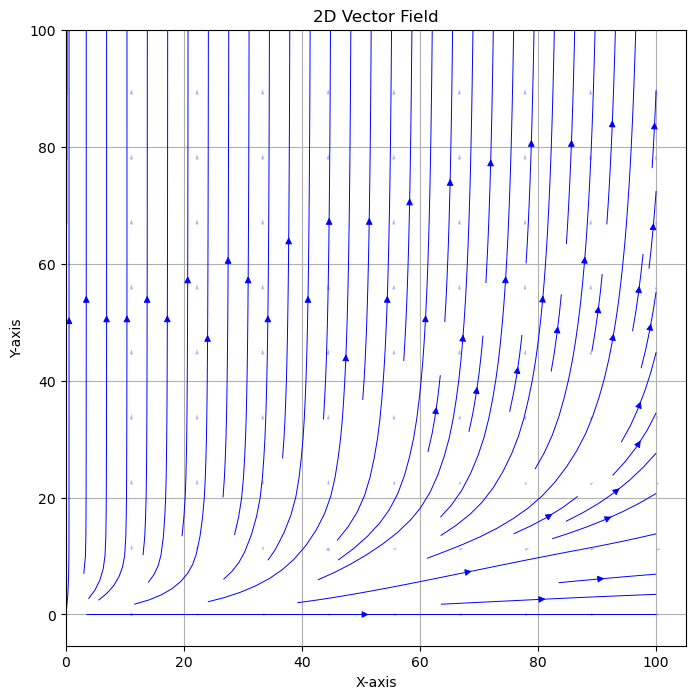

In [181]:
plot_2D_vector_field_over_grid(easygrid, solver, control=np.array([0.5]), streamplot=True, resolution = 10)

In [182]:
#Test Case
bounds = infgrid.tf_bounds
X1 = np.linspace(bounds[0][0], bounds[0][1], 10)
X2 = np.linspace(bounds[1][0], bounds[1][1], 10)
X1, X2 = np.meshgrid(X1, X2)
X1 = np.vectorize(infgrid.inverse_transformation[0])(X1)
X2 = np.vectorize(infgrid.inverse_transformation[1])(X2)
X1
U, V = create_2D_vectorfield(X1, X2, control=np.array([0.5]), solver=solver)

[Text(-0.2, 0, '−0.2'), Text(0.0, 0, '0.0'), Text(0.2, 0, '0.2'), Text(0.4000000000000001, 0, '0.4'), Text(0.6000000000000001, 0, '0.6'), Text(0.8, 0, '0.8'), Text(1.0000000000000002, 0, '1.0'), Text(1.2000000000000002, 0, '1.2')]


/tmp/ipykernel_7219/1101653202.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


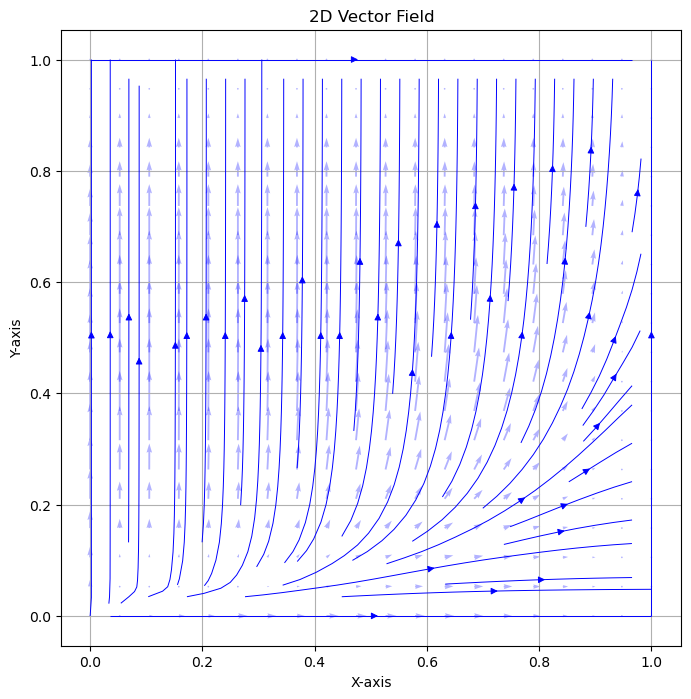

In [183]:
plot_2D_vector_field_over_grid(infgrid, solver, np.array([0.5]), mytransformation_derivative, streamplot=True, resolution = 20)